In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('styles.csv', nrows=1000)

In [ ]:
data.articleType.value_counts()[:10]

Tshirts         142
Shirts           76
Watches          71
Sports Shoes     55
Casual Shoes     50
Tops             48
Handbags         45
Kurtas           32
Flip Flops       29
Sandals          26
Name: articleType, dtype: int64

In [ ]:
values = ["Tshirts", "Shirts", "Watches", "Sports Shoes", "Casual Shoes", "Tops", "Handbags", "Kurtas", "Flip Flops", "Sandals"]

data = data[data.articleType.isin(["Tshirts","Watches"])]

data["articleType"] = data["articleType"].replace({"Sports Shoes": "Shoes", "Casual Shoes": "Shoes"})
data=data[['id','articleType']]
data.head(15)

,id,articleType
2,59263,Watches
4,53759,Tshirts
5,1855,Tshirts
9,30039,Watches
16,29928,Watches
20,17429,Watches
27,7990,Tshirts
31,4729,Tshirts
38,51658,Watches
39,3954,Tshirts


In [ ]:
images=[]
labels=[]
import shutil

for index, row in data.iterrows():
#     images.append(image.img_to_array(image.load_img('images/'+str(row.id)+'.jpg')))

    shutil.copy('images/'+str(row.id)+'.jpg', 'data_folder')

    image = cv2.imread('images/'+str(row.id)+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)
    labels.append(row.articleType)
images=np.array(images)

In [ ]:
images[0].shape

(80, 60)

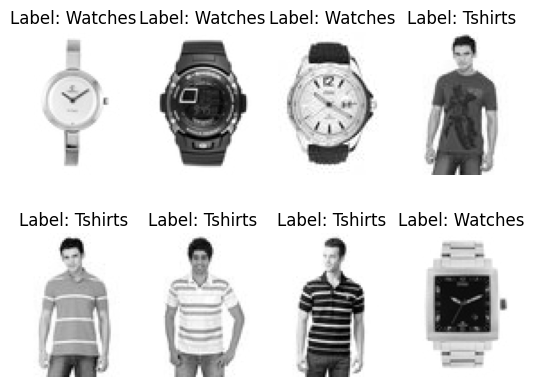

In [ ]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i*5], cmap="gray")
    plt.title(f"Label: {labels[i*5]}")
    plt.axis('off')
plt.show()

In [ ]:

input_dim=80*60
x_train=np.array(images).reshape(images.shape[0], input_dim)
x_train.shape

(213, 4800)

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

In [ ]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024/4, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512/4))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256/4))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model


In [ ]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256*4, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512*4))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024*4))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [ ]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)


In [ ]:
def plot_generated_images(epoch, generator):
    num_of_images = 5
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise,verbose=0).reshape(num_of_images, 80, 60)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [ ]:
discrim_losses = []
generator_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake MNIST images
            generated_images = generator.predict(noise,verbose=0)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)
        if ep % 5 == 0:
            print('epoch: ', ep)
            print(ep, "discriminator loss: ", d_loss,"generator loss: ", gan_loss)
            plot_generated_images(ep, generator)

epoch:  0
0 discriminator loss:  2137.7275390625 generator loss:  1.991559624671936


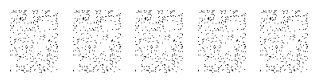

epoch:  5
5 discriminator loss:  464.7828369140625 generator loss:  1.5746707916259766


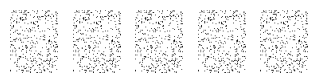

epoch:  10
10 discriminator loss:  168.6477813720703 generator loss:  27.01412582397461


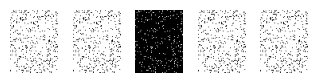

epoch:  15
15 discriminator loss:  46.88130569458008 generator loss:  1.3881356716156006


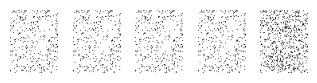

epoch:  20
20 discriminator loss:  47.06248092651367 generator loss:  1.5452139377593994


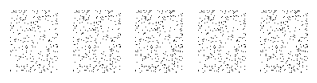

epoch:  25
25 discriminator loss:  32.992279052734375 generator loss:  1.3030980825424194


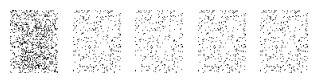

epoch:  30
30 discriminator loss:  26.662853240966797 generator loss:  1.3541491031646729


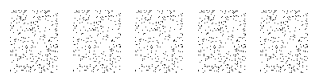

epoch:  35
35 discriminator loss:  17.974075317382812 generator loss:  1.8258610963821411


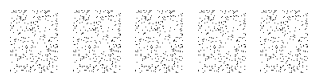

epoch:  40
40 discriminator loss:  18.952678680419922 generator loss:  2.506885051727295


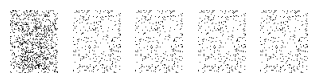

epoch:  45
45 discriminator loss:  12.853639602661133 generator loss:  2.3090481758117676


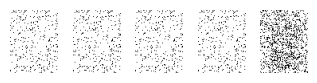

epoch:  50
50 discriminator loss:  7.757749080657959 generator loss:  2.7910256385803223


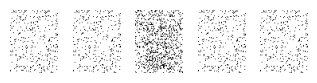

epoch:  55
55 discriminator loss:  7.583798885345459 generator loss:  2.632640838623047


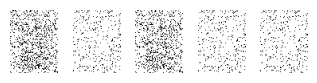

epoch:  60
60 discriminator loss:  5.713376045227051 generator loss:  2.9045495986938477


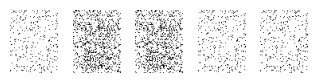

epoch:  65
65 discriminator loss:  5.414830207824707 generator loss:  2.6699628829956055


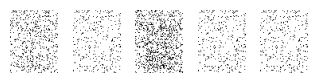

epoch:  70
70 discriminator loss:  4.694003582000732 generator loss:  2.865581512451172


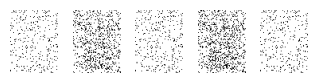

epoch:  75
75 discriminator loss:  3.771482229232788 generator loss:  2.8738675117492676


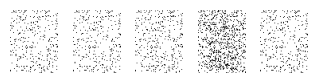

epoch:  80
80 discriminator loss:  4.857301235198975 generator loss:  2.8033156394958496


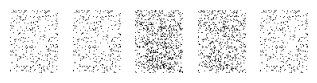

epoch:  85
85 discriminator loss:  2.839632987976074 generator loss:  2.7957117557525635


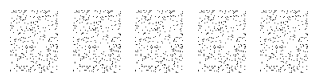

epoch:  90
90 discriminator loss:  2.2334039211273193 generator loss:  2.9666614532470703


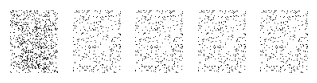

epoch:  95
95 discriminator loss:  1.9462400674819946 generator loss:  2.9377055168151855


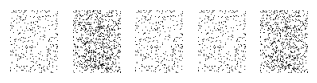

epoch:  100
100 discriminator loss:  1.5679494142532349 generator loss:  3.052098274230957


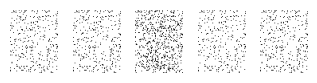

epoch:  105
105 discriminator loss:  1.5416842699050903 generator loss:  3.016308307647705


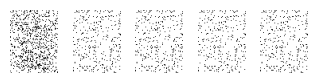

epoch:  110
110 discriminator loss:  1.2999422550201416 generator loss:  3.129439353942871


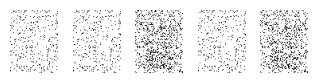

epoch:  115
115 discriminator loss:  0.8255794048309326 generator loss:  3.105067729949951


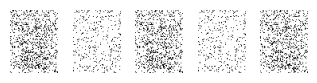

epoch:  120
120 discriminator loss:  1.1028215885162354 generator loss:  3.1639926433563232


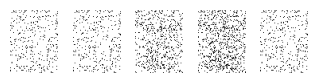

epoch:  125
125 discriminator loss:  0.9204638600349426 generator loss:  3.1656131744384766


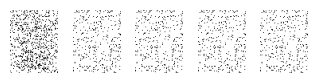

epoch:  130
130 discriminator loss:  0.4607366919517517 generator loss:  3.206869125366211


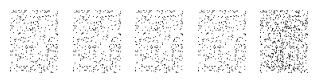

epoch:  135
135 discriminator loss:  0.5067050457000732 generator loss:  3.2057747840881348


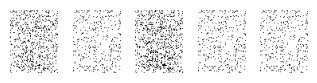

epoch:  140
140 discriminator loss:  0.4140923023223877 generator loss:  3.2206430435180664


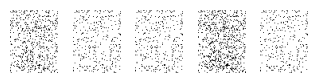

epoch:  145
145 discriminator loss:  0.4498007297515869 generator loss:  3.233769655227661


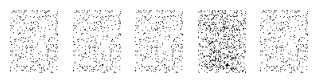

epoch:  150
150 discriminator loss:  0.4185861647129059 generator loss:  3.264523506164551


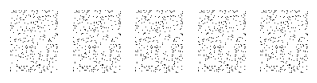

epoch:  155
155 discriminator loss:  0.35353517532348633 generator loss:  3.274165391921997


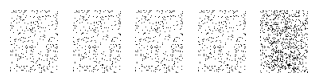

epoch:  160
160 discriminator loss:  0.3588540554046631 generator loss:  3.2773523330688477


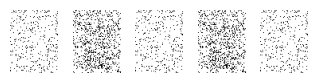

epoch:  165
165 discriminator loss:  0.40623152256011963 generator loss:  3.2991456985473633


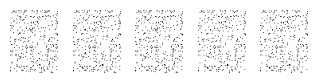

epoch:  170
170 discriminator loss:  0.42479994893074036 generator loss:  3.3086438179016113


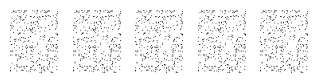

epoch:  175
175 discriminator loss:  0.2886722981929779 generator loss:  3.3329696655273438


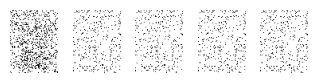

epoch:  180
180 discriminator loss:  0.275243878364563 generator loss:  3.3715755939483643


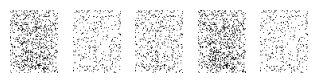

epoch:  185
185 discriminator loss:  0.3012053370475769 generator loss:  3.3581063747406006


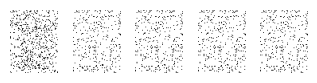

epoch:  190
190 discriminator loss:  0.3213665187358856 generator loss:  3.3677172660827637


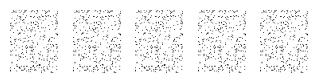

epoch:  195
195 discriminator loss:  0.37389329075813293 generator loss:  3.3876516819000244


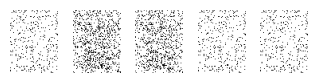

epoch:  200
200 discriminator loss:  0.35557588934898376 generator loss:  3.403242826461792


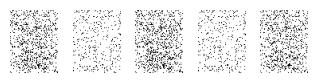

epoch:  205
205 discriminator loss:  0.330431193113327 generator loss:  3.4211108684539795


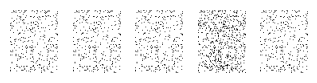

epoch:  210
210 discriminator loss:  0.7364751100540161 generator loss:  3.440697431564331


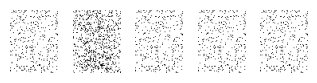

epoch:  215
215 discriminator loss:  0.32438063621520996 generator loss:  3.452566146850586


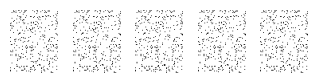

epoch:  220
220 discriminator loss:  0.3360750377178192 generator loss:  3.47117018699646


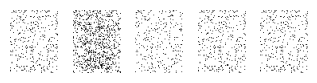

epoch:  225
225 discriminator loss:  0.4305442273616791 generator loss:  3.4904422760009766


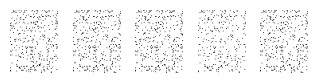

epoch:  230
230 discriminator loss:  0.39135241508483887 generator loss:  3.506300926208496


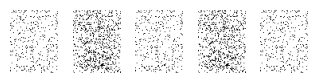

epoch:  235
235 discriminator loss:  0.3638986647129059 generator loss:  3.5012054443359375


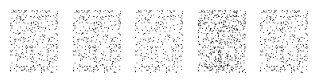

epoch:  240
240 discriminator loss:  0.3658735454082489 generator loss:  3.5324058532714844


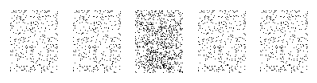

epoch:  245
245 discriminator loss:  0.30619296431541443 generator loss:  3.5556235313415527


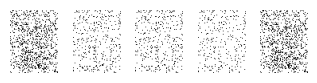

epoch:  250
250 discriminator loss:  0.3032912313938141 generator loss:  3.5562992095947266


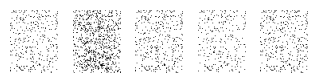

epoch:  255
255 discriminator loss:  0.4875960946083069 generator loss:  3.5584378242492676


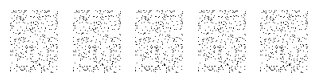

epoch:  260
260 discriminator loss:  0.4405681788921356 generator loss:  3.5714235305786133


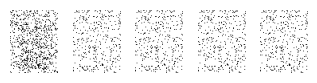

epoch:  265
265 discriminator loss:  0.26426365971565247 generator loss:  3.5863447189331055


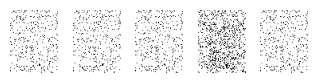

epoch:  270
270 discriminator loss:  0.30366435647010803 generator loss:  3.5812621116638184


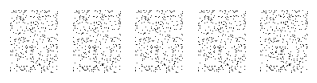

epoch:  275
275 discriminator loss:  0.3479989767074585 generator loss:  3.59775447845459


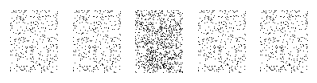

epoch:  280
280 discriminator loss:  0.32827335596084595 generator loss:  3.610183000564575


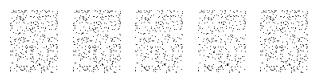

epoch:  285
285 discriminator loss:  0.3606283366680145 generator loss:  3.6131114959716797


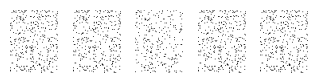

epoch:  290
290 discriminator loss:  0.38497376441955566 generator loss:  3.648735761642456


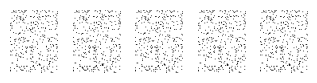

epoch:  295
295 discriminator loss:  0.4486858546733856 generator loss:  3.6406145095825195


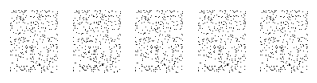

epoch:  300
300 discriminator loss:  0.3336636424064636 generator loss:  3.6480770111083984


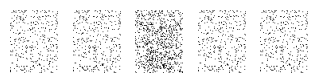

In [ ]:
epochs = 300
batch_size = 32
train_model(epochs, batch_size)
